<a href="https://colab.research.google.com/github/love-bees/dataHacker/blob/master/TF2_LINREG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with TensorFlow 2.1.0


Description

## The Math behind it

In order to get the linear regression equation, we need to know how to *mathematically* draw a line. We define a line in the slope-intercept form of a linear equation:

$
y = kx+n
$

Where $k$ represents the slope and $n$ represents the y-axis intercept.<br>
From there, we will define our linear regression equation:

$ y = wx+b$

$
\hat y = wx + b \longrightarrow h(x,w,b) = wx+b
$

Where $\hat y$ represents the linear regression equation (also denoted as $h(x,w,b)$ and in this case we will call it a hypothesis function). The function depends on 3 variables: data ($x$), weight($w$) and bias ($b$). We will modify the weight and bias in such a way that for any given data, the equation will give us an output ($\hat y$) that we want.

How is this practically achived? We will construct a graph that learns the gradient of the slope ($w$) and bias ($b$) through multiple iterations. Each iteration has the aim to close the gap between the hypothesis and the true output, making the linear predition more and more percise. We achive this by comparing the prediction to the true output and calculating the cost function. By minimizing the cost function (also called the loss function), we can improve the percision of our prediction.

Let's try using the Mean Squared Error (MSE) for our loss function. MSE measures the average squared difference between the prediction and true output. The result is a single number representing the cost (or loss, score) associated with our current parameters. The goal is to minimize MSE to minimize the loss in order to get a good accuracy.

Let's see how the MSE looks like in our case:

$
MSE = \frac{1}{N} \sum \limits_{i=0}^{N} (y_i - \hat y_i)^2 = \frac{1}{N} \sum \limits_{i=0}^{N} (y_i - (wx_i+b))^2
$

Where $y_i$ represents our true output, $\hat y_i$ our predicted output or hypothesis and $N$ represents the number of samples. <br>
We will also need the first derivative of the MSE function:

$ MSE'(y,\hat y) = \frac{1}{N} \sum\limits_{i=0}^{N} 2(y_i - \hat y_i)$

We will use gradient descent to update our parameters $w$ and $b$. This is the general formula:

$\theta = \theta - \alpha\frac{\partial MSE}{\partial \theta}$<br>

Where $\theta$ represents our parameters and MSE (Mean Squared Error) represents the loss function and alpha represents our learning rate or step size.

We optimize both $w$ and $b$ by finding the partial derivatives with respect to the loss function:

$
\frac{\partial MSE}{\partial w} = \frac{\partial MSE}{\partial \hat y} \frac{\partial \hat y}{\partial w} = MSE'(y,\hat y) * x
$
<br>
$
\frac{\partial MSE}{\partial b} = \frac{\partial MSE}{\partial \hat y} \frac{\partial \hat y}{\partial b} = MSE'(y,\hat y)
$

## That was too much math! How do I code all this?



Let's start out by trying to find a suitable dataset. We need a dataset which has at least two continuous parameters. In this example, I'll be using <a href="https://www.kaggle.com/mohansacharya/graduate-admissions">Graduate Admissions data from Kaggle</a>. You should be able to access it by following the link and clicking on "Download".

Now, let's import the data using pandas and preview the table:

In [0]:
import pandas as pd
data = pd.read_csv("Admission_Predict.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


From there, we can see that there's 7 continuous parameters (GRE Score, TOEFL Score, University Rating, SOP, LOR, CGPA and Chance of Admit) and one binary (Research). Let's filter out the data we need, normalize it and plot it using matplotlib. I want the GRE score to be a feature (or input) for my model and the Chance of Admit to be the label (or the output).

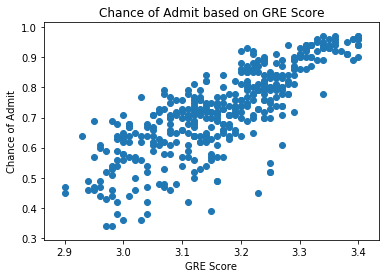

In [0]:
#picking two continuous variables and normalizing them

X = data[['GRE Score']].values/100
Y = data[['Chance of Admit ']].values

#displaying the data

import matplotlib.pyplot as plt

plt.scatter(X,Y)
plt.xlabel('GRE Score');
plt.ylabel('Chance of Admit');
plt.title('Chance of Admit based on GRE Score');

It's obvious from the plot that there's some sort of linear trend. The higher the GRE score, the higher the chance of admittance to a university. Let's prep this data for the model. I'll be using the train_test_split function to quickly separate the data into two groups: one of training the model and one for testing the model's accuracy. <br>
Once we separate the two for features and labels each, we can store them in constant tensors.

In [0]:
#splitting the features and labels into train and test data
#!pip install tf-nightly-2.0-preview
import tensorflow as tf
from sklearn.model_selection import train_test_split

train_features , test_features ,train_labels, test_labels = train_test_split(X, Y, test_size = 0.2)

train_X = tf.constant( train_features , dtype=tf.float32 )
train_Y = tf.constant( train_labels , dtype=tf.float32 )

test_X = tf.constant( test_features , dtype=tf.float32 )
test_Y = tf.constant( test_labels , dtype=tf.float32 )

In case you're wondering, yes this is TensorFlow 2.0:

In [0]:
tf.__version__

'2.0.0-dev20191002'

The next step is to define the methods we described in the math part of the post. We'll be using:
<ol>
    <li>Mean Squared Error</li>
    <li>Mean Squared Error derivative</li>
    <li>Linear Regression function or the Hypothesis function</li>
</ol>

In [0]:
#defining the mean square error, its' derivative and the hypothesis function

def MSE(Y,y_pred):
    return tf.reduce_mean(tf.square(y_pred-Y))

def MSE_derivative(Y,y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - Y)), [1, 1])

def h(X,weights,bias):
    return tf.tensordot(X, weights, axes=1)+bias

In [0]:
#generating data for learning and shuffling the dataset
num_epochs = 100
num_samples = train_X.shape[0]
batch_size = 10
learning_rate = 0.001

dataset = tf.data.Dataset.from_tensor_slices((train_X , train_Y))
dataset = dataset.shuffle( 500 ).repeat( num_epochs ).batch( batch_size )
iterator = dataset.__iter__()

In [0]:
import numpy as np

#generating number of features, a random weight and setting the starting bias to 0
num_features = train_X.shape[1]
weights = tf.random.normal((num_features, 1))
bias = tf.random.normal((num_features, 1))

#will be used for plotting after
epochs_plot = list()
loss_plot = list()

for i in range(num_epochs) :

    epoch_loss = list()
    for j in range(int(num_samples/batch_size)):

        x_batch , y_batch = iterator.get_next()

        output = h(x_batch, weights, bias)
        loss = epoch_loss.append( MSE( y_batch , output ).numpy() )

        dJ_dH = MSE_derivative(y_batch, output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean( dJ_dH * dH_dW )
        dJ_dB = tf.reduce_mean( dJ_dH )

        weights -= (learning_rate * dJ_dW)
        bias -= (learning_rate * dJ_dB)
    loss = np.array(epoch_loss).mean()
    epochs_plot.append(i + 1)
    loss_plot.append(loss)

    print('Loss is', loss )

Loss is 2.3291197
Loss is 0.56981844
Loss is 0.14529167
Loss is 0.042081505
Loss is 0.016930804
Loss is 0.010927974
Loss is 0.00948506
Loss is 0.009118935
Loss is 0.009030057
Loss is 0.00901003
Loss is 0.009007443
Loss is 0.0089906985
Loss is 0.008987643
Loss is 0.008990044
Loss is 0.008997655
Loss is 0.0089953765
Loss is 0.008990699
Loss is 0.008993749
Loss is 0.00898518
Loss is 0.008992183
Loss is 0.008992709
Loss is 0.008987026
Loss is 0.00899381
Loss is 0.008988684
Loss is 0.008988193
Loss is 0.00899677
Loss is 0.00899353
Loss is 0.008999046
Loss is 0.008982924
Loss is 0.008986652
Loss is 0.008992771
Loss is 0.008992004
Loss is 0.008993243
Loss is 0.008981857
Loss is 0.008993154
Loss is 0.008994317
Loss is 0.008988845
Loss is 0.008989212
Loss is 0.0089832
Loss is 0.008993372
Loss is 0.008991183
Loss is 0.00899195
Loss is 0.008993356
Loss is 0.008998759
Loss is 0.008989245
Loss is 0.0089868
Loss is 0.008995121
Loss is 0.008983777
Loss is 0.008987667
Loss is 0.008988316
Loss is 0.008

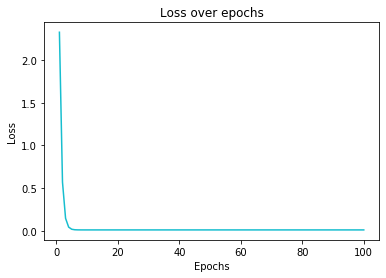

In [0]:
plt.plot(epochs_plot, loss_plot, color='C9')
plt.title('Loss over epochs');
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [0]:
output = h(test_X , weights , bias )
labels = test_Y

accuracy_op = tf.metrics.MeanAbsoluteError()
accuracy_op.update_state( labels , output )
print( 'Mean Absolute Error = {}'.format( accuracy_op.result().numpy() ) )

Mean Absolute Error = 0.06439020484685898


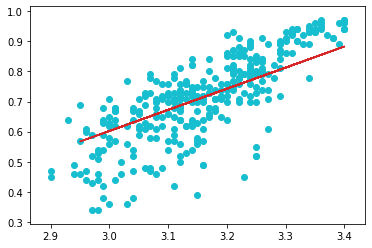

In [0]:
plt.scatter(train_X,train_Y, color='C9')
plt.plot(test_X, output, color='C3')